<a href="https://colab.research.google.com/github/snu-digital-finance/ProductionML/blob/main/Difference%20of%20Weight%20Matrices.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Terminology

In [76]:
from dataclasses import dataclass
@dataclass
class Notation:
    y1: str = "K-Intensive"
    y2: str = "Inverted K-Intensive"
    y3: str = "L-Intensive"

note = Notation()

## Visualization

In [77]:

import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from itertools import count
import numpy as np
import re
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Lambda


# === 1. Data ===
SEED=42
np.random.seed(SEED)
tf.random.set_seed(SEED)
rng = np.random.default_rng(SEED)

Fixed_Dense = lambda n, activation: Dense(
    n, activation = activation,
    kernel_initializer=tf.keras.initializers.GlorotUniform(seed=SEED),
)

In [78]:
FIG_NO = count(1)

def _expand_title(title_prefix: str) -> str:
    """
    Parse tokens like "<TL K^3 + y2 → y2>" or "[TL y1 + y2 → y2]" and
    convert to a readable figure title, e.g., "y1 transfer learned with y2"
    (if target == finetune) or "y1 transfer learned with y2 to predict y3".
    Falls back to the raw prefix (with brackets removed) if parsing fails.
    """
    # extract inside <> or []
    m = re.search(r'[\[<]\s*(.*?)\s*[\]>]', title_prefix or "")
    core = (m.group(1) if m else title_prefix or "").strip()

    # try to parse "TL A + B → T"
    m2 = re.match(r'^TL\s+(.+?)\s*\+\s*(.+?)\s*→\s*(.+)$', core)
    if not m2: # remove brackets and return
      return core
    A, B, T = [s.strip() for s in m2.groups()]
    return f"{A} transfer learned with {B}" + " to predict {T}" if T != B else ""


def draw_triptych(title_prefix, Kv, Lv, y_true, y_pred,
                  fig_no=None, caption=None, y_lim=None, show=True):
    if fig_no is None:
        fig_no = next(FIG_NO)

    mse = (y_true - y_pred) ** 2
    cmap_y = "Greys"
    m_true, m_pred = "o", "^"
    edge = "black"

    fig = plt.figure(figsize=(10, 4))
    gs = GridSpec(nrows=1, ncols=3, figure=fig, width_ratios=[1, 1, 1])

    # (a) True — 3D
    ax1 = fig.add_subplot(gs[0, 0], projection='3d')
    ax1.scatter(Kv, Lv, y_true, c=y_true, cmap=cmap_y,
                alpha=0.8, s=14, marker=m_true, edgecolor=edge, linewidth=0.3)
    ax1.set_title("(a) True Y")
    ax1.set_xlabel("K"); ax1.set_ylabel("L"); ax1.set_zlabel("Y")
    ax1.set_xlim(0, 1); ax1.set_ylim(0, 1)
    if y_lim is not None:
        ax1.set_zlim(*y_lim)

    # (b) Predicted — 3D
    ax2 = fig.add_subplot(gs[0, 1], projection='3d')
    ax2.scatter(Kv, Lv, y_pred, c=y_pred, cmap=cmap_y,
                alpha=0.8, s=14, marker=m_pred, edgecolor=edge, linewidth=0.3)
    ax2.set_title("(b) Predicted Ŷ")
    ax2.set_xlabel("K"); ax2.set_ylabel("L"); ax2.set_zlabel("Ŷ")
    ax2.set_xlim(0, 1); ax2.set_ylim(0, 1)
    if y_lim is not None:
        ax2.set_zlim(*y_lim)

    # (c) MSE — 2D: x = varying axis (K or L), y = MSE
    ax3 = fig.add_subplot(gs[0, 2])
    if np.nanstd(Lv) < 1e-9:
        x_vals, x_label = np.ravel(Kv), "K"
    elif np.nanstd(Kv) < 1e-9:
        x_vals, x_label = np.ravel(Lv), "L"
    else:
        x_vals, x_label = np.ravel(Kv), "K"
    ax3.scatter(x_vals, np.ravel(mse), c="dimgray", s=12,
                marker="s", edgecolor=edge, linewidth=0.3)
    ax3.set_title("(c) MSE (Y−Ŷ)^2\n")
    ax3.set_xlabel(x_label); ax3.set_ylabel("\n\n\n\nMSE")
    ax3.set_xlim(0, 1); ax3.set_ylim(0, 1)

    # Figure title from expanded prefix
    pretty = _expand_title(title_prefix)
    cap = f"Figure {fig_no}. {pretty}"
    if caption:
        cap += f" — {caption}"
    fig.suptitle(cap, fontsize=18, y=0.9)

    fig.subplots_adjust(left=0.05, right=0.98, top=0.9, bottom=0.05, wspace=0.35)
    ax1.text2D(0.02, 0.92, "○ True,  △ Pred,  ■ MSE",
               transform=ax1.transAxes, fontsize=9)

    if show:
      plt.tight_layout(rect=[0.05, 0.05, 0.95, 0.95])
      plt.show()


## Data Generation

In [79]:

n = 1000
noise_scale = 0.05

# K-intensive: K~U(0,1), L=0
K = np.random.rand(n, 1)
L0 = np.zeros((n, 1))
X_K = np.hstack([K, L0])

# L-intensive: K=0, L~U(0,1)
K0 = np.zeros((n, 1))
L = np.random.rand(n, 1)
X_L = np.hstack([K0, L])

# Targets with noise
y1 = K**3 + np.random.normal(0, noise_scale, size=(n, 1))      # K³ + noise
y2 = -K**3 + np.random.normal(0, noise_scale, size=(n, 1))     # −K³ + noise
y3 = L**3 + np.random.normal(0, noise_scale, size=(n, 1))      # L³ + noise
y4 = -L**3 + np.random.normal(0, noise_scale, size=(n, 1))


## Build & Train Model

In [80]:
from sklearn.metrics import mean_squared_error

def run_prediction(m_y2, m_y3, title, fig_no=1, caption=['', '', ''], isTL=False):
    global FIG_NO
    y2_pred = m_y2.predict(X_K, verbose=0)
    y3_pred = m_y3.predict(X_L, verbose=0)
    FIG_NO = count(fig_no)
    t = f'{title}\n{note.y1} '
    if isTL:
      t += '+ '
      draw_triptych(f"{t}{note.y2} → {note.y2}{': '+caption[0]}", K, L0,  y2, y2_pred, y_lim = (-1,0))
      draw_triptych(f"{t}{note.y2} → {note.y2}{': '+caption[1]}", K, L0,  y1, -y2_pred, y_lim = (-1,0))
      draw_triptych(f"{t}{note.y3} → {note.y3}{': '+caption[2]}", K0, L, y3, y3_pred, y_lim = (0,1))
    else:
      draw_triptych(f"{t}→ {note.y1}", K, L0, y1, y2_pred)
      draw_triptych(f"{t}→ {note.y2}", K, L0, y2, y2_pred)
      draw_triptych(f"{t}→ {note.y3}", K0, L, y3, y3_pred, y_lim=(0, 1))

In [81]:
# Original Model - 5 layers trained on y1
def build_model(fixed=True):
    d = Fixed_Dense if fixed else Dense
    m = Sequential([
        tf.keras.Input(shape=(2,)),
        Lambda(tf.nn.relu, name="input_relu"),
        d(64, activation="relu"),
        d(16, activation="relu"),
        d(4, activation="relu"),
        d(1, activation="linear")
    ])
    m.compile(optimizer="adam", loss="mse")
    return m

model = build_model()
model.fit(X_K, y1, epochs=100, batch_size=32, verbose=0)
model.summary()

from tensorflow.keras.models import clone_model

def build_tl_model_flexible(trainable=1, seed=None):
    m = clone_model(model)
    m.build(model.input_shape)
    m.set_weights(model.get_weights())   # <-- keep transferred weights

    # 1) freeze all
    for lyr in m.layers:
        lyr.trainable = False

    # 2) open only the last `trainable` layers (no re-init!)
    for lyr in m.layers[-trainable:]:
        lyr.trainable = True

    m.compile(optimizer="adam", loss="mse")
    return m


def build_tl_y2_y3(epochs, trainable=1):
    m_y2 = build_tl_model_flexible(trainable=trainable)
    m_y2.fit(X_K, y2, epochs=epochs, batch_size=32, verbose=0)
    m_y3 = build_tl_model_flexible(trainable=trainable)
    m_y3.fit(X_L, y3, epochs=epochs, batch_size=32, verbose=0)

    for l2, l3 in zip(m_y2.layers, m_y3.layers):
        print(f"{l2.name:25s} tr={l2.trainable}   {l3.name:25s} tr={l3.trainable}")
    return m_y2, m_y3

model_tf_2layer_y2, model_tf_2layer_y3 = build_tl_y2_y3(100, trainable=2)

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_relu (Lambda)             │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │           192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 16)             │         1,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 4)              │            68 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │             5 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,917 (15.30 KB)

 Trainable params: 1,305 (5.10 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2,612 (10.21 KB)

input_relu                tr=False   input_relu                tr=False
dense_4                   tr=False   dense_4                   tr=False
dense_5                   tr=False   dense_5                   tr=False
dense_6                   tr=True   dense_6                   tr=True
dense_7                   tr=True   dense_7                   tr=True


## 1. Interpolation (TL)

In [82]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.models import clone_model

# ---------- helpers ----------

def clone_architecture_like(m):
    """Clone architecture only, then build with the same input shape."""
    mc = clone_model(m)
    # build by calling once (assumes input shape (2,))
    _ = mc(tf.zeros((1, 2)))
    return mc

def layer_weight_slices(model):
    """
    Map each layer to the flat weight indices in model.get_weights().
    Returns: list of tuples (layer_name, start, end) covering all weights.
    """
    slices = []
    idx = 0
    for lyr in model.layers:
        n = len(lyr.get_weights())
        if n > 0:
            slices.append((lyr.name, idx, idx + n))
            idx += n
    return slices  # order matches model.get_weights()

def make_grid(nk=60, nl=60):
    K = np.linspace(0, 1, nk)
    L = np.linspace(0, 1, nl)
    KK, LL = np.meshgrid(K, L, indexing="xy")
    Xg = np.stack([KK.ravel(), LL.ravel()], axis=1).astype(np.float32)
    return KK, LL, Xg

def plot_triplet(title, KK, LL, Z_src, Z_mid, Z_tgt, zlim=None):
    fig = plt.figure(figsize=(15, 4.6))
    panels = [(Z_src, "(a) Source"),
              (Z_mid, "(b) Interp λ"),
              (Z_tgt, "(c) Target (TL)")]
    for i, (Z, ttl) in enumerate(panels, 1):
        ax = fig.add_subplot(1, 3, i, projection='3d')
        ax.plot_surface(
            KK, LL, Z,
            cmap="Greys",
            edgecolor='k',
            linewidth=0.2,
            antialiased=True,
            alpha=0.95,
        )
        ax.set_title(ttl)
        ax.set_xlabel("K")
        ax.set_ylabel("L")
        ax.set_zlabel("Ŷ")
        ax.set_xlim(0, 1)
        ax.set_ylim(0, 1)
        if zlim is not None:
            ax.set_zlim(*zlim)
    fig.suptitle(title, y=0.98, fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

# ---------- main: last-layer-only interpolation ----------

def visualize_last_layer_interpolation(model_src, model_tgt,
                                       lambdas=np.linspace(0, 1, 6),
                                       zlim=None):
    """
    Interpolate ONLY the last trainable layer's weights between model_src and model_tgt.

    Assumptions:
      - model_src and model_tgt share the same architecture.
      - The only difference between them is the last layer's weights
        (backbone already frozen and identical).

    lambdas : iterable of λ in [0,1].
    """
    # 1) sanity check: same architecture
    w_src = model_src.get_weights()
    w_tgt = model_tgt.get_weights()
    assert len(w_src) == len(w_tgt), "Models must share architecture (same number of weights)."
    for a, b in zip(w_src, w_tgt):
        if a.shape != b.shape:
            raise ValueError("Weight shapes differ; ensure identical architectures.")

    # 2) find the last trainable layer slice (usually the final Dense(1))
    slices = layer_weight_slices(model_src)
    last_layer_name, start, end = slices[-1]   # last layer with weights
    print(f"Interpolating last layer only: {last_layer_name}, weights indices [{start}:{end})")

    # 3) prepare grid and fixed endpoints
    KK, LL, Xg = make_grid()
    Z_src = model_src.predict(Xg, verbose=0).reshape(KK.shape)
    Z_tgt = model_tgt.predict(Xg, verbose=0).reshape(KK.shape)

    # 4) clone a fresh model once; reuse to set interpolated weights
    m_mid = clone_architecture_like(model_src)

    for lam in lambdas:
        # start from source weights
        w_mid = list(w_src)
        # interpolate ONLY last layer weights (kernel, bias, etc.)
        for i in range(start, end):
            w_mid[i] = (1.0 - lam) * w_src[i] - lam * w_tgt[i]

        m_mid.set_weights(w_mid)
        Z_mid = m_mid.predict(Xg, verbose=0).reshape(KK.shape)

        title = f"Last-layer weight interpolation  λ={lam:.2f}"
        plot_triplet(title, KK, LL, Z_src, Z_mid, Z_tgt, zlim=zlim)


In [97]:
def _plot_scatter(ax, x, y, z):
    ax.scatter(x, y, z, c=z, cmap='gray', s=20)


def _plot_axes_label(ax, xlabel: str, ylabel: str, zlabel: str):
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_zlabel(zlabel)
    ax.grid(True)


def plot_weights_3d(layers, subtitle:str=''):
    num_layers = len(layers)
    # Increase figure size and adjust layout
    fig = plt.figure(figsize=(4*num_layers, 6))
    fig.suptitle(f"[{subtitle}] Original Model - Transfer Learning", fontsize=16)
    # Adjust spacing between subplots and margins
    # fig.subplots_adjust(wspace=0.5, left=0.05, right=0.95, top=0.9, bottom=0.1)
    for i, layer in enumerate(layers):
        w, _ = layer.get_weights()
        ax = fig.add_subplot(1, num_layers, i+1, projection='3d')
        X_vals, Y_vals = np.meshgrid(np.arange(w.shape[0]), np.arange(w.shape[1]))
        Z_vals = w.flatten()
        _plot_scatter(ax, X_vals.flatten(), Y_vals.flatten(), Z_vals)
        ax.set_zlim(
            -0.75, 0.75
        )
        _plot_axes_label(ax, 'Input Neuron', 'Output Neuron', 'Weight Value')
        ax.set_title(f"Layer {i+2}\n" + \
            f"X:({X_vals.shape})\nY:({Y_vals.shape})\nZ:({w.shape})")
    plt.show()
    plt.close()


def visualize_difference_weight_matrix(model_src, model_tgt,
                                       zlim=None):
    """
    Interpolate ONLY the last trainable layer's weights between model_src and model_tgt.

    Assumptions:
      - model_src and model_tgt share the same architecture.
      - The only difference between them is the last layer's weights
        (backbone already frozen and identical).

    lambdas : iterable of λ in [0,1].
    """
    # 1) sanity check: same architecture
    w_src = model_src.get_weights()
    w_tgt = model_tgt.get_weights()
    assert len(w_src) == len(w_tgt), "Models must share architecture (same number of weights)."
    for a, b in zip(w_src, w_tgt):
        if a.shape != b.shape:
            raise ValueError("Weight shapes differ; ensure identical architectures.")

    # 2) find the last trainable layer slice (usually the final Dense(1))
    slices = layer_weight_slices(model_src)
    last_layer_name, start, end = slices[-1]   # last layer with weights
    print(f"Interpolating last layer only: {last_layer_name}, weights indices [{start}:{end})")

    # 3) prepare grid and fixed endpoints
    KK, LL, Xg = make_grid()
    # Z_src = model_src.predict(Xg, verbose=0).reshape(KK.shape)
    # Z_tgt = model_tgt.predict(Xg, verbose=0).reshape(KK.shape)

    # 4) clone a fresh model once; reuse to set interpolated weights
    m_mid = clone_architecture_like(model_src)

    # start from source weights
    w_mid = list(w_src)
    # interpolate ONLY last layer weights (kernel, bias, etc.)
    # for i in range(start, end):
    for i in range(1, 5):
      m_mid.layers[i].set_weights([
          model_src.layers[i].get_weights()[0]-model_tgt.layers[i].get_weights()[0],
          model_src.layers[i].get_weights()[1]-model_tgt.layers[i].get_weights()[1],
          ])


    #m_mid.set_weights(w_mid)
    # Z_mid = m_mid.predict(Xg, verbose=0).reshape(KK.shape)

    title = f"Last-layer Weight Difference"
    # plot_triplet(title, KK, LL, Z_src, Z_mid, Z_tgt, zlim=zlim)

    #plot_weights_3d(model_src.layers[1:], subtitle='Original Model')
    plot_weights_3d(m_mid.layers[1:], subtitle='Difference of Weight Matrices')
    #plot_weights_3d(model_tgt.layers[1:], subtitle='Transfer Learning')




Interpolating last layer only: dense_7, weights indices [6:8)


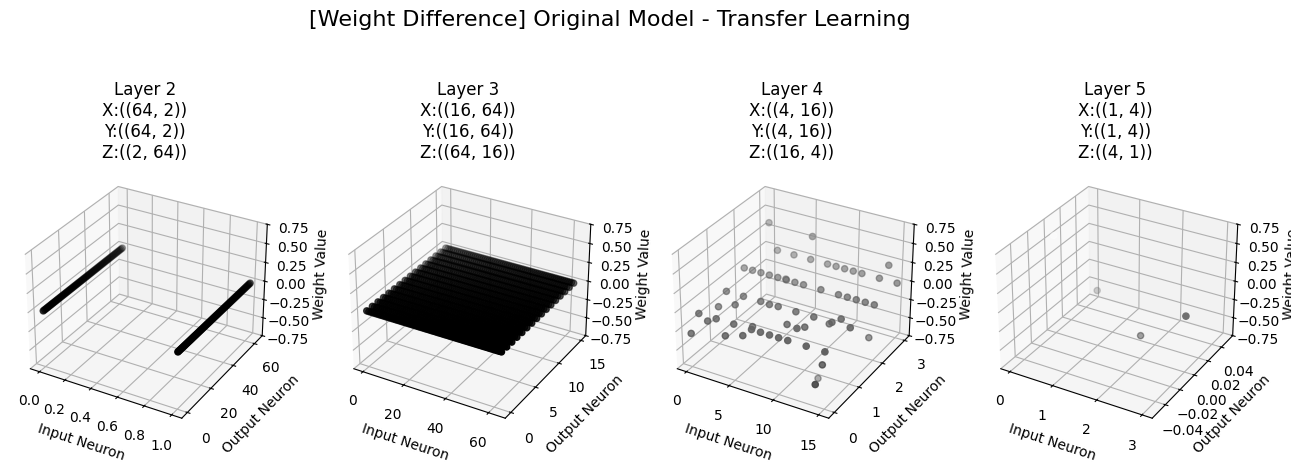

Interpolating last layer only: dense_7, weights indices [6:8)


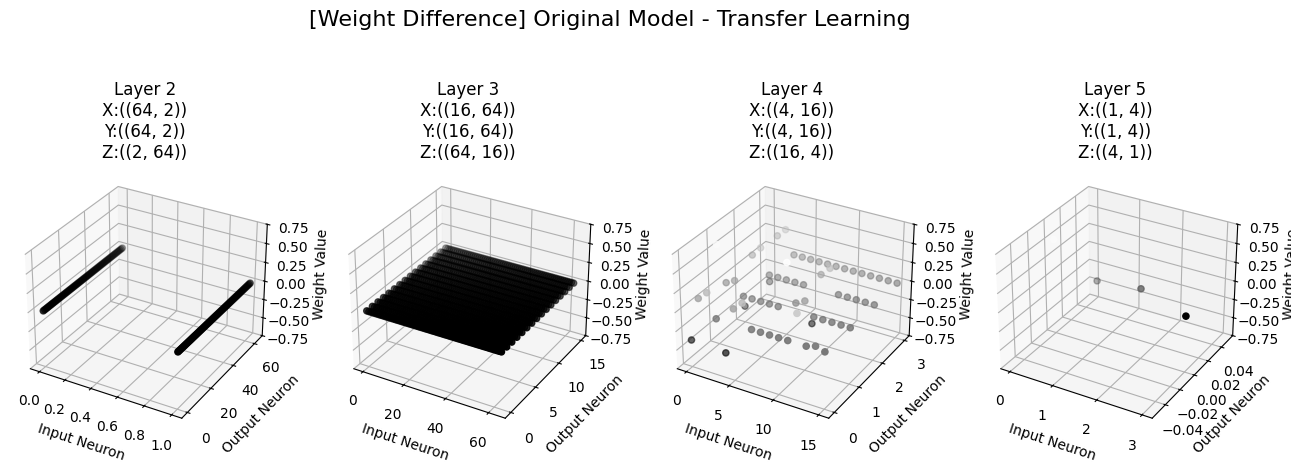

In [98]:
import numpy as np

# interpolation 스케줄
lambdas = np.linspace(0.0, 1.0, 6)   # 0.00, 0.20, ..., 1.00
zlim = (0, 1)                        # 필요하면 조정

# 1) y1(K^3) → y3(L^3) 로 TL된 모델 사이에서 "마지막 레이어만" 보간
visualize_difference_weight_matrix(
    model_src=model,                 # 원본: y1 = K^3 로 학습된 5-layer 모델
    model_tgt=model_tf_2layer_y3,    # TL 대상: y3 = L^3 로 fine-tune된 모델
)

# 2) (선택) y1(K^3) → y2(-K^3) 로 TL된 모델 사이에서 마지막 레이어만 보간
visualize_difference_weight_matrix(
    model_src=model,
    model_tgt=model_tf_2layer_y2,     # y2가 음수까지 가므로 범위 넉넉하게
)
